In [1]:
from py2neo import authenticate, NodeSelector, Graph, Node, Relationship

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
lang_dict = {'DE': 'German', 'EN': 'English', 'ES': 'Spanish', 'FA': 'Persian', 'RU': 'Russian', 'FR': 'French', \
                 'IT': 'Italian', 'JA': 'Japanese', 'PL': 'Polish', 'PT': 'Portuguese', 'ZH': 'Chinese'}


#### Let's compare with the entire Wikipedias for context
Data source: https://en.wikipedia.org/wiki/List_of_Wikipedias#Detailed_list , accessed in April 2018.

In [4]:
# Top 20 Wikipedia language domains by graph size
full_wikis_details_df = pd.read_csv('../data/wikipedia_lang_domains_stats.tsv', sep='\t', thousands=',')
full_wikis_details_df

,Language,Language_local,Wiki,Articles,Total,Edits,Admins,Users,Active Users,Images,Depth
0,English,English,en,5630962,44876307,834345194,1219,33490584,135693,867971,903.11
1,Cebuano,Cebuano,ceb,5382900,8964287,22242798,5,47234,165,0,1.10
2,Swedish,svenska,sv,3784418,7657446,42772036,65,609998,2616,0,5.85
3,German,Deutsch,de,2177052,6123026,175896919,196,2896133,18339,129366,94.38
4,French,français,fr,1979744,9427436,147557087,165,3091375,19338,54097,221.51
5,Dutch,Nederlands,nl,1930224,3960343,51394760,44,913657,3745,26,14.36
6,Russian,русский,ru,1469981,5647815,92093944,82,2288103,10743,209416,131.71
7,Italian,italiano,it,1434066,5377980,96261950,114,1653157,8387,141911,135.38
8,Spanish,español,es,1407841,6311950,106966420,70,4982817,16708,0,205.63
9,Polish,polski,pl,1277779,2839441,53139895,106,884607,4179,34,27.95


Note: the majority of the articles in Swedish, Cebuano and Waray Wikipedias were generated by a single bot, [Lsjbot](https://en.wikipedia.org/wiki/Lsjbot).

In [5]:
full_wikis_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
Language          20 non-null object
Language_local    20 non-null object
Wiki              20 non-null object
Articles          20 non-null int64
Total             20 non-null int64
Edits             20 non-null int64
Admins            20 non-null int64
Users             20 non-null int64
Active Users      20 non-null int64
Images            20 non-null int64
Depth             20 non-null float64
dtypes: float64(1), int64(7), object(3)
memory usage: 1.8+ KB


In [6]:
# Let's also add Wikipedia project creation date and the current number of bots
def add_date_n_bots(lang_code, date, bots):
    ind = full_wikis_details_df[full_wikis_details_df['Wiki'] == lang_code.lower()].index[0]
    full_wikis_details_df.at[ind, 'date_created'] = date
    full_wikis_details_df.at[ind, 'bots_count'] = bots


In [7]:
# Date is text (easier to use as label later), bots count is num
add_date_n_bots('en', '200101', 308)
add_date_n_bots('ru', '200105', 82)
add_date_n_bots('de', '200103', 379)
add_date_n_bots('fr', '200103', 114)
add_date_n_bots('es', '200105', 38)
add_date_n_bots('it', '200105', 105)
add_date_n_bots('pl', '200109', 48)
add_date_n_bots('ja', '200105', 63)
add_date_n_bots('zh', '200105', 64)
add_date_n_bots('pt', '200105', 214)
add_date_n_bots('fa', '200312', 176)


In [8]:
# keep only the language domains for which we have clickstream data
full_wikis_details_df.dropna(inplace=True)

In [9]:
#full_wikis_details_df.at[ind, 'date_created'] = '200105'
full_wikis_details_df

,Language,Language_local,Wiki,Articles,Total,Edits,Admins,Users,Active Users,Images,Depth,date_created,bots_count
0,English,English,en,5630962,44876307,834345194,1219,33490584,135693,867971,903.11,200101,308.0
3,German,Deutsch,de,2177052,6123026,175896919,196,2896133,18339,129366,94.38,200103,379.0
4,French,français,fr,1979744,9427436,147557087,165,3091375,19338,54097,221.51,200103,114.0
6,Russian,русский,ru,1469981,5647815,92093944,82,2288103,10743,209416,131.71,200105,82.0
7,Italian,italiano,it,1434066,5377980,96261950,114,1653157,8387,141911,135.38,200105,105.0
8,Spanish,español,es,1407841,6311950,106966420,70,4982817,16708,0,205.63,200105,38.0
9,Polish,polski,pl,1277779,2839441,53139895,106,884607,4179,34,27.95,200109,48.0
12,Japanese,日本語,ja,1104839,3270753,68180410,43,1324380,13413,85208,80.11,200105,63.0
13,Chinese,中文,zh,1003465,5378951,49068621,79,2509488,8257,48990,173.44,200105,64.0
14,Portuguese,português,pt,997517,4612889,51761188,79,2084569,6156,48735,147.40,200105,214.0


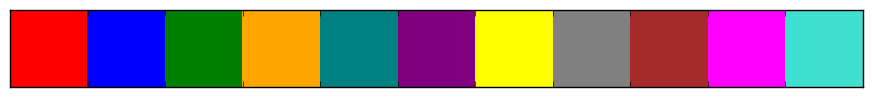

In [10]:
# color pallete for plotting the 11 language domains
pal = sns.color_palette(palette= ['red','blue', 'green', 'orange', 'teal', 'purple', 
                                  'yellow', 'grey', 'brown', 'magenta', 'turquoise'], n_colors=11)
sns.palplot(pal)

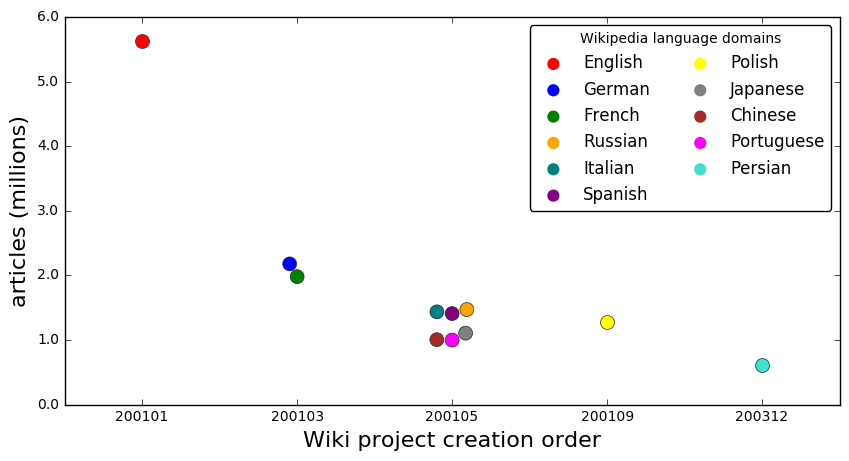

In [19]:
plt.figure(figsize=(10,5))
fig = sns.swarmplot(y = 'Articles', x = 'date_created', hue='Language', palette=pal,
              size=10, edgecolor='gray', linewidth=0.5,
              data = full_wikis_details_df[['Language', 'date_created', 'Articles']])
plt.xlabel('Wiki project creation order', fontsize=16)
plt.ylabel('articles (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000)
#plt.title('Wikipedia language domains sizes')

plt.legend(ncol=2, scatterpoints = 1, fancybox = True, title= 'Wikipedia language domains');

Let's compare the article counts in the Wikipedia projects vs the article counts in the clickstream data, to get a sense of what proportion of the Wikipedias was traversed by users in March 2018.

In [13]:
# unpickle
with open("pickles/w2a_graph_sizes_df.pkl", 'rb') as picklefile: 
    w2a_graph_sizes_df = pickle.load(picklefile)

w2a_graph_sizes_df

,language,language_code,articles_count,external_sources_count,edges_count,references_count,refs_per_edge_avg
9,English,EN,4636312,5,25917378,7209691324,278.18
1,Russian,RU,1310230,5,2712051,704827086,259.89
0,German,DE,1307048,5,5305000,775318583,146.15
3,French,FR,1018507,5,3545691,584620558,164.88
10,Japanese,JA,880747,5,2295941,765429220,333.38
7,Spanish,ES,802360,5,3409055,915554698,268.57
5,Italian,IT,698313,5,2919343,476970761,163.38
6,Portuguese,PT,523616,5,1773920,315514276,177.86
4,Chinese,ZH,497074,5,1238296,291813076,235.66
8,Polish,PL,493158,5,1556704,202264461,129.93


In [14]:
full_wiki_articles = full_wikis_details_df[['Language', 'Articles']]
full_wiki_articles.rename(columns={"Language": "language", "Articles": "all_articles"}, inplace=True)
clickstream_articles = w2a_graph_sizes_df[['language', 'articles_count']]
clickstream_articles.rename(columns={"articles_count": "clickstream_articles"}, inplace=True)

wiki_usage_df = full_wiki_articles.merge(clickstream_articles, on='language', how='outer')

wiki_usage_df['clickstream_articles_pct'] = round(wiki_usage_df['clickstream_articles'] * 1.0/wiki_usage_df['all_articles'], 3)

wiki_usage_df

,language,all_articles,clickstream_articles,clickstream_articles_pct
0,English,5630962,4636312,0.823
1,German,2177052,1307048,0.600
2,French,1979744,1018507,0.514
3,Russian,1469981,1310230,0.891
4,Italian,1434066,698313,0.487
5,Spanish,1407841,802360,0.570
6,Polish,1277779,493158,0.386
7,Japanese,1104839,880747,0.797
8,Chinese,1003465,497074,0.495
9,Portuguese,997517,523616,0.525


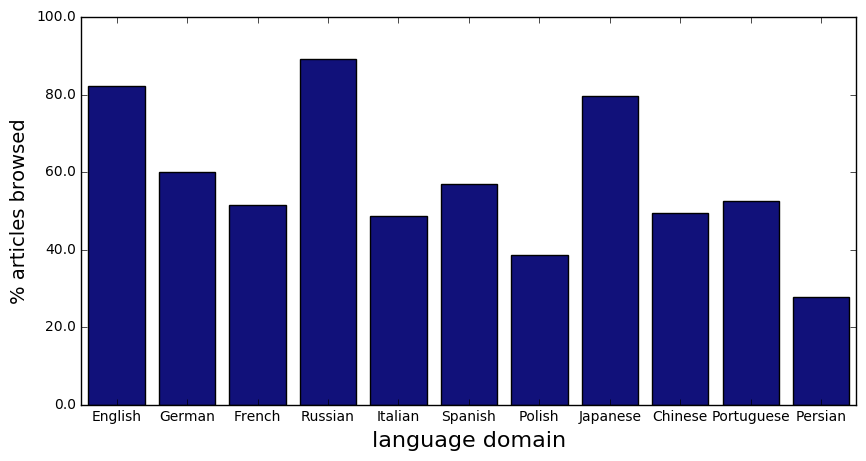

In [23]:
plt.figure(figsize=(10,5))
fig = sns.barplot(y = 'clickstream_articles_pct', x = 'language', 
              data = wiki_usage_df[['language', 'clickstream_articles_pct']], 
              color = 'darkblue')
plt.ylim(0, 1)
plt.xlabel('language domain', fontsize=16)
plt.ylabel('% articles browsed', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.yticks(fig.get_yticks(), fig.get_yticks()*100);

In [16]:
wiki_usage_df2 = wiki_usage_df[['language', 'all_articles', 'clickstream_articles']].rename( \
    columns={"all_articles": "all Wiki", "clickstream_articles": "clickstream"})
wiki_usage_df3 = \
pd.melt(wiki_usage_df2[['language', 'all Wiki', 'clickstream']], \
        id_vars="language", var_name="article count source", value_name="article count")
wiki_usage_df3

,language,article count source,article count
0,English,all Wiki,5630962
1,German,all Wiki,2177052
2,French,all Wiki,1979744
3,Russian,all Wiki,1469981
4,Italian,all Wiki,1434066
5,Spanish,all Wiki,1407841
6,Polish,all Wiki,1277779
7,Japanese,all Wiki,1104839
8,Chinese,all Wiki,1003465
9,Portuguese,all Wiki,997517


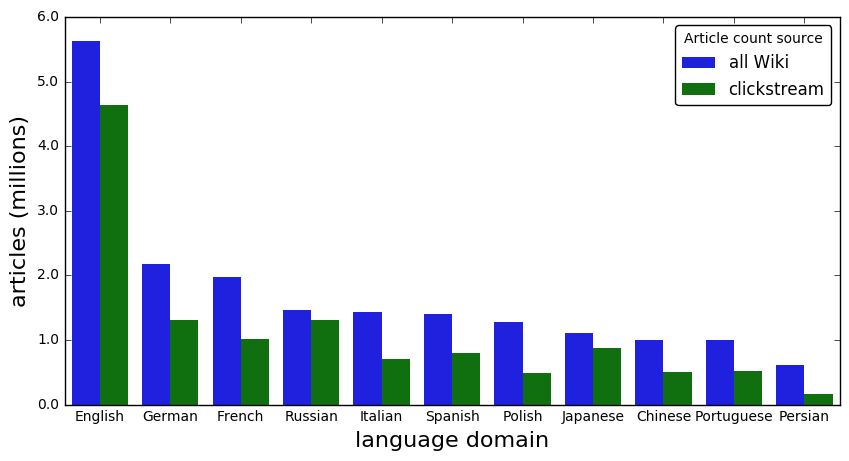

In [24]:
plt.figure(figsize=(10,5))
fig = sns.barplot(y = 'article count', x = 'language', hue='article count source',
              linewidth = 0,
              data = wiki_usage_df3)
plt.xlabel('language domain', fontsize=16)
plt.ylabel('articles (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10, bottom='off')
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000)

plt.legend(fancybox = True, title= 'Article count source');

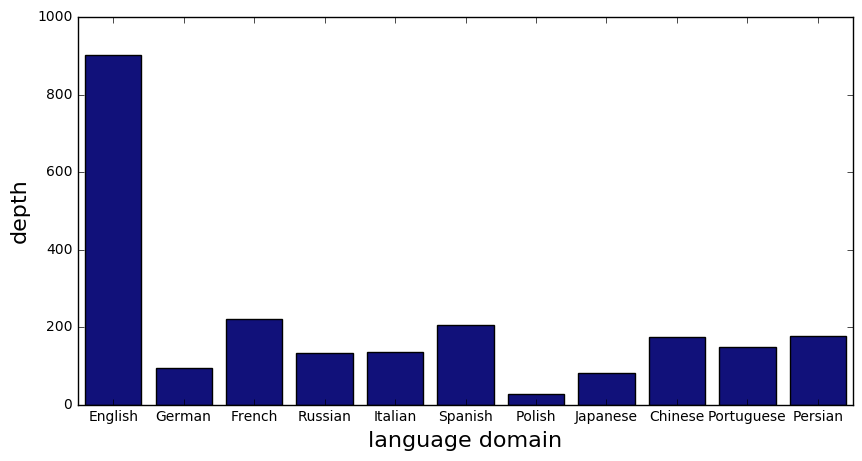

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(y = 'Depth', x = 'Language', 
              data = full_wikis_details_df[['Language', 'Depth']], 
              color = 'darkblue')
plt.xlabel('language domain', fontsize=16)
plt.ylabel('depth', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)